In [1]:
import os, json, random, shutil, math
from pathlib import Path
from collections import defaultdict

from PIL import Image
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
### --------- CONFIG ---------
images_dir = Path('train_images_labels_targets/train/images')  
labels_dir = Path('train_images_labels_targets/train/labels')  
crops_dir  = Path('crops')                                    

resize_hw = (224, 224)   
pad_pixels = 4           

DAMAGE_CLASSES = [
    'no-damage',
    'minor-damage',
    'major-damage',
    'destroyed',
    'un-classified',
]

In [3]:
def _ensure_class_folders(root: Path):
    for cls in DAMAGE_CLASSES:
        (root / cls).mkdir(parents=True, exist_ok=True)

def _polygon_to_bbox(poly: Polygon, pad: int, w: int, h: int):
    minx, miny, maxx, maxy = poly.bounds
    return (
        max(int(minx) - pad, 0),
        max(int(miny) - pad, 0),
        min(int(maxx) + pad, w - 1),
        min(int(maxy) + pad, h - 1),
    )

def extract_crops(image_dir: Path, label_dir: Path, out_dir: Path,
                  resize=(224, 224), pad: int = 4, overwrite: bool = False):
    """Export one crop JPEG per building footprint."""
    _ensure_class_folders(out_dir)
    img_files = [p for p in image_dir.iterdir() if p.suffix.lower() in ('.png', '.jpg', '.tif', '.tiff')]
    for img_path in tqdm(img_files, desc='Cropping'):
        stem = img_path.stem
        lbl_path = label_dir / f'{stem}.json'
        if not lbl_path.exists():
            continue
        with open(lbl_path) as f:
            label_data = json.load(f)
        image = Image.open(img_path).convert('RGB')
        w, h = image.size
        for idx, feat in enumerate(label_data['features']['xy']):
            damage = feat['properties'].get('subtype', 'no-damage')
            if damage not in DAMAGE_CLASSES:
                damage = 'un-classified'
            geom = wkt.loads(feat['wkt'])
            polys = list(geom) if isinstance(geom, MultiPolygon) else [geom]
            poly = max(polys, key=lambda p: p.area)
            bbox = _polygon_to_bbox(poly, pad, w, h)
            crop = image.crop(bbox).resize(resize, Image.BILINEAR)
            out_path = out_dir / damage / f'{stem}_{idx}.jpg'
            if overwrite or not out_path.exists():
                crop.save(out_path)
    print('Cropping done →', out_dir)


In [4]:
# --- Run once; comment out after crops exist ---
extract_crops(images_dir, labels_dir, crops_dir, resize_hw, pad_pixels)

Cropping: 100%|██████████| 5598/5598 [12:17<00:00,  7.59it/s]

Cropping done → crops


In [5]:
tfm_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
tfm_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

full_ds = datasets.ImageFolder(crops_dir, transform=tfm_train)
val_len = int(len(full_ds) * 0.2)
train_len = len(full_ds) - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len])
val_ds.dataset.transform = tfm_val

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, pin_memory=True)

print(f'Train samples: {len(train_ds)},  Val samples: {len(val_ds)}')

Train samples: 260460,  Val samples: 65114


In [6]:
model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(DAMAGE_CLASSES))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\dipen/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 7.94MB/s]


In [7]:
best_acc = 0.0
num_epochs = 10  # adjust
history = defaultdict(list)

for epoch in range(1, num_epochs+1):
    # ----- train -----
    model.train(); running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f'Train {epoch}/{num_epochs}'):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    # ----- val -----
    model.eval(); correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = 100.0 * correct / total
    history['train_loss'].append(train_loss); history['val_acc'].append(val_acc)

    print(f'Epoch {epoch}: train_loss={train_loss:.4f}  val_acc={val_acc:.2f}%')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), crops_dir / 'efficientnetb0_damage_best.pth')

    scheduler.step()

print(f'Training done. Best val acc: {best_acc:.2f}%')

Train 1/10: 100%|██████████| 8140/8140 [1:14:26<00:00,  1.82it/s]


Epoch 1: train_loss=0.3087  val_acc=91.85%


Train 2/10: 100%|██████████| 8140/8140 [26:47<00:00,  5.06it/s]


Epoch 2: train_loss=0.2354  val_acc=92.12%


Train 3/10: 100%|██████████| 8140/8140 [26:13<00:00,  5.17it/s]


Epoch 3: train_loss=0.2077  val_acc=92.32%


Train 4/10: 100%|██████████| 8140/8140 [26:03<00:00,  5.20it/s]


Epoch 4: train_loss=0.1616  val_acc=92.58%


Train 5/10: 100%|██████████| 8140/8140 [26:04<00:00,  5.20it/s]


Epoch 5: train_loss=0.1483  val_acc=92.60%


Train 6/10: 100%|██████████| 8140/8140 [26:53<00:00,  5.04it/s]


Epoch 6: train_loss=0.1384  val_acc=92.34%


Train 7/10:  21%|██▏       | 1740/8140 [09:11<33:47,  3.16it/s]


KeyboardInterrupt: 

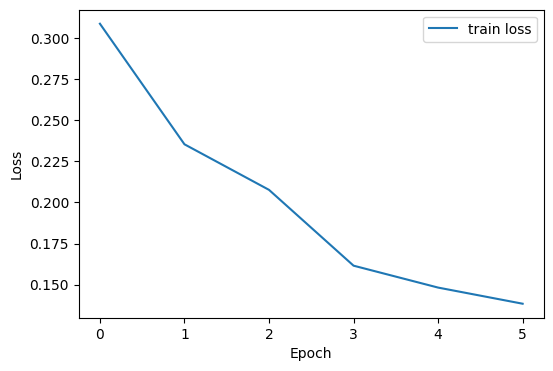

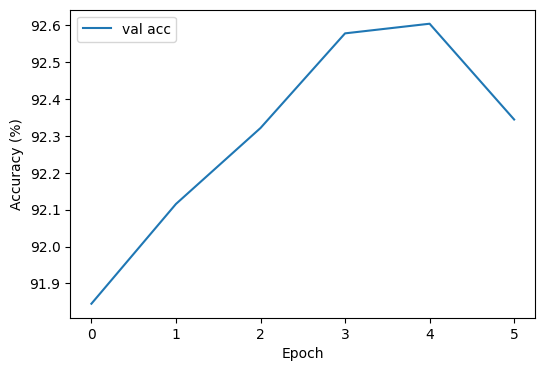

In [8]:
plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='train loss')
plt.ylabel('Loss'); plt.xlabel('Epoch'); plt.legend(); plt.show()
plt.figure(figsize=(6,4))
plt.plot(history['val_acc'], label='val acc')
plt.ylabel('Accuracy (%)'); plt.xlabel('Epoch'); plt.legend(); plt.show()

In [ ]:
def predict_single(img_path: Path, model, tfm=tfm_val):
    img = Image.open(img_path).convert('RGB')
    x = tfm(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        pred = logits.argmax(1).item()
    return DAMAGE_CLASSES[pred]

# Example:
# sample_img = list((crops_dir/'destroyed').glob('*.jpg'))[0]
# print(sample_img, '→', predict_single(sample_img, model))